# Polynomial Regression: OLS, Ridge, and LASSO — GD vs SGD
Seed = 3155, degree = 10, N = 1000, noise ~ N(0,1).  

In [1]:
# Imports and constants
import numpy as np
import matplotlib.pyplot as plt

from mlmods.data_utils import make_dataset, add_intercept 
from mlmods.data_utils import standardize_train_test as standardize

from mlmods.metrics_utils import mse, train_mse_over_traj

from mlmods.grads import ols_grad_full_builder, ridge_grad_full_builder, lasso_grad_full_builder
from mlmods.grads import ols_grad_minibatch, ridge_grad_minibatch, lasso_grad_minibatch

from mlmods.trainers import train_full_batch_family, train_sgd_family
from mlmods.closed_form import ols_closed_form, ridge_closed_form
from mlmods.plotting_utils import plot_convergence, plot_final_coeffs_with_cf


# Global config
SEED   = 3155
N      = 1000
DEGREE = 7
NOISE  = 1.0
LAM    = 1e-1    
ITERS  = 300
BATCH  = 20  

np.random.seed(SEED)

# Generate raw training and test data (no scaling or intercept added yet)
X_tr_raw, X_te_raw, y_tr, y_te = make_dataset(N, DEGREE, seed=SEED, noise_std=NOISE)

## OLS: GD vs SGD 


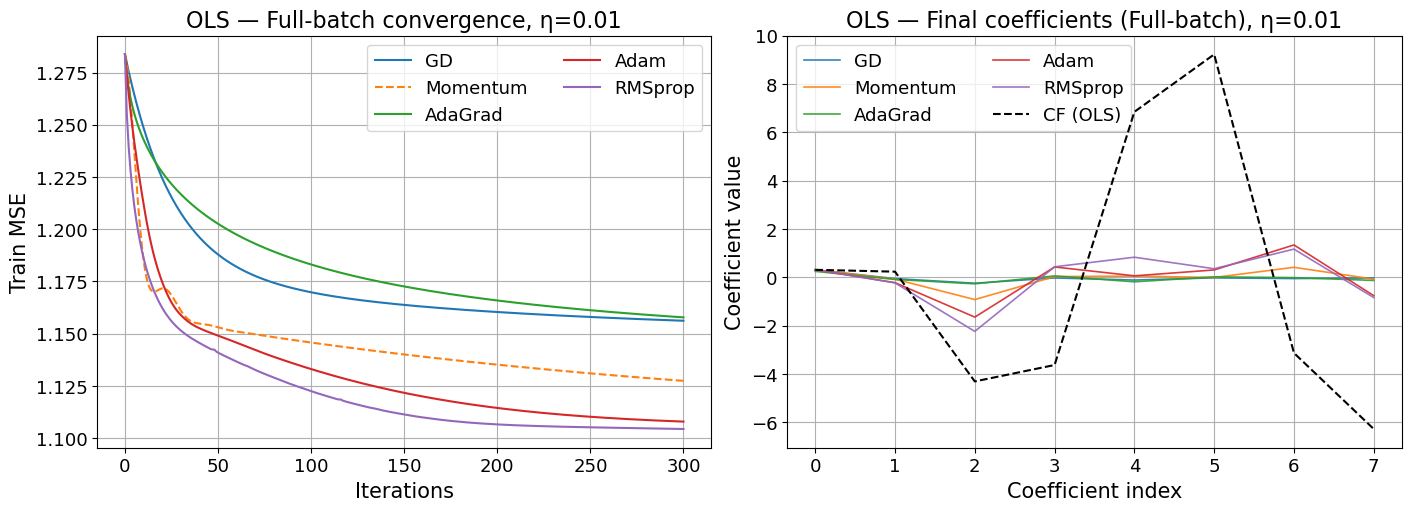

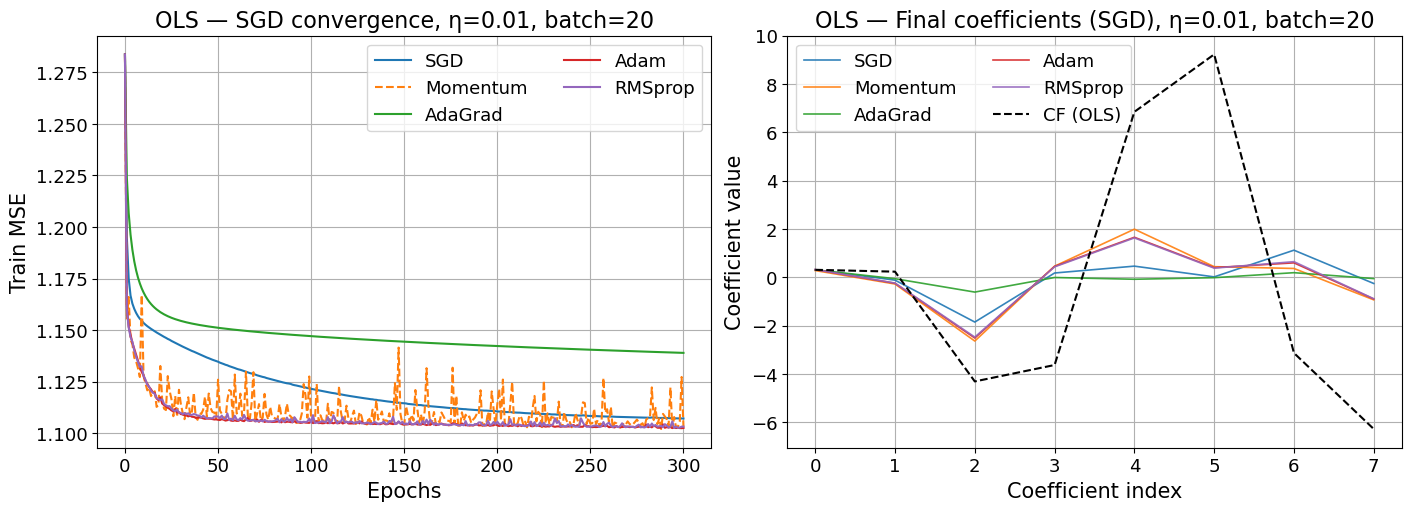

In [2]:
# OLS (center-only features)

# Center features using train stats then add intercept.
Xc_tr_t, Xc_te_t, mu_c, sd_c = standardize(X_tr_raw, X_te_raw, mode="center")
Xc_tr = add_intercept(Xc_tr_t)
Xc_te = add_intercept(Xc_te_t)


# OLS gradients (full + minibatch) on centered design
ols_full = ols_grad_full_builder(Xc_tr, y_tr)
def ols_mb(theta, Xb, yb):
    return ols_grad_minibatch(theta, Xb, yb)

# Learning rates
lr_fb  = 0.01 
lr_sgd = 0.01 

# Train families
fb_ols = train_full_batch_family(ols_full, Xc_tr, y_tr, lr=lr_fb,  iters=ITERS)
mb_ols = train_sgd_family(ols_mb, Xc_tr, y_tr, lr=lr_sgd, epochs=ITERS, batch_size=BATCH, seed=SEED)

# Closed form (same centered design with manual intercept)
theta_cf_ols = ols_closed_form(Xc_tr, y_tr)

# Convergence (MSE) and final coefficients
conv_fb_ols = {k: train_mse_over_traj(Xc_tr, y_tr, traj, mse) for k, (_, traj) in fb_ols.items()}
conv_mb_ols = {k: train_mse_over_traj(Xc_tr, y_tr, traj, mse) for k, (_, traj) in mb_ols.items()}


# OLS: Full-batch
fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(
    axes[0], conv_fb_ols,
    f"OLS — Full-batch convergence, η={lr_fb:g}",
    "Iterations", ylabel="Train MSE",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plot_final_coeffs_with_cf(
    axes[1], fb_ols, theta_cf_ols,
    f"OLS — Final coefficients (Full-batch), η={lr_fb:g}",
    cf_label="CF (OLS)",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plt.savefig("OlsGd.pdf", dpi=300)
plt.show()

# OLS: SGD
fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(
    axes[0], conv_mb_ols,
    f"OLS — SGD convergence, η={lr_sgd:g}, batch={BATCH}",
    "Epochs", ylabel="Train MSE",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plot_final_coeffs_with_cf(
    axes[1], mb_ols, theta_cf_ols,
    f"OLS — Final coefficients (SGD), η={lr_sgd:g}, batch={BATCH}",
    cf_label="CF (OLS)",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plt.savefig("OlsSgd.pdf", dpi=300)
plt.show()

## Ridge: GD vs SGD

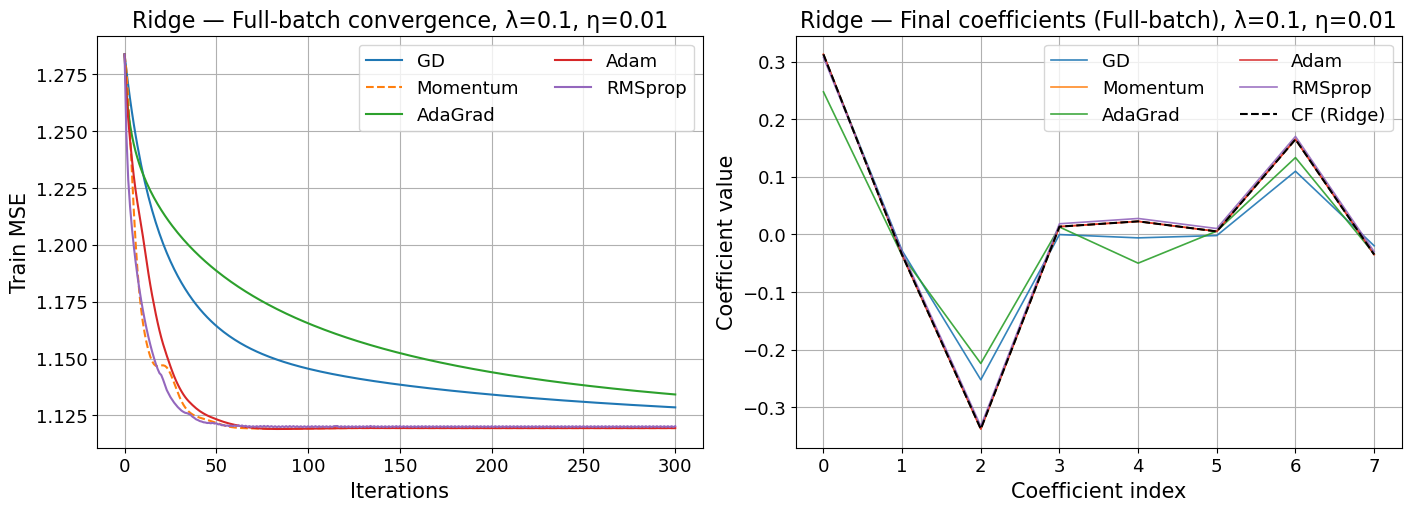

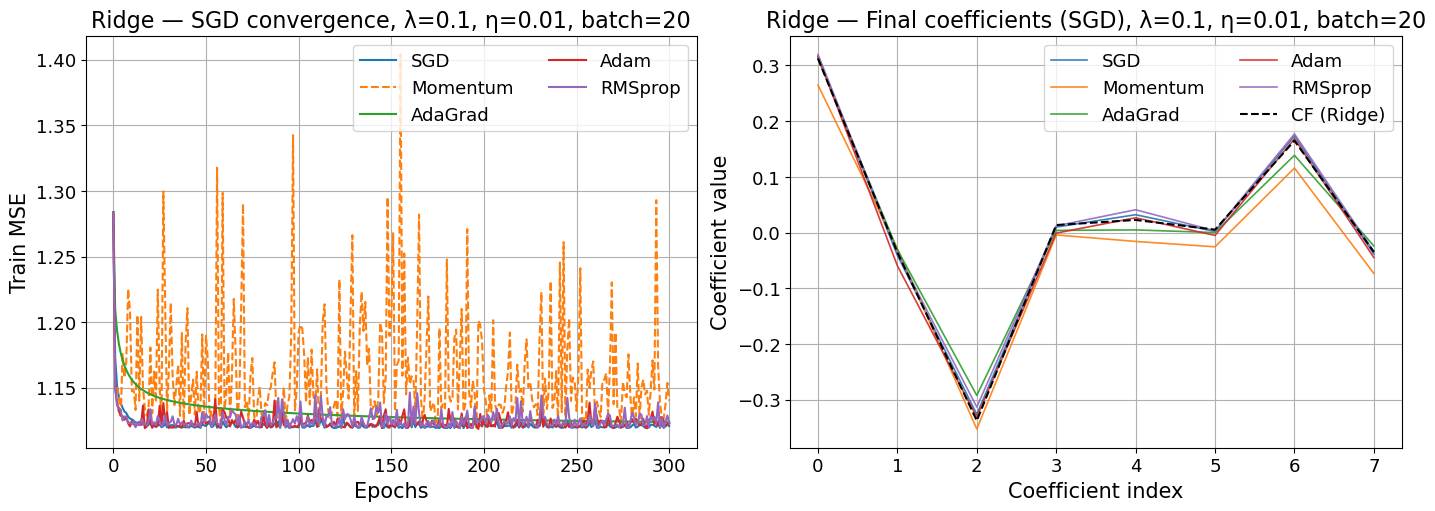

In [3]:
# Ridge (z-score features, intercept not penalized)

# Z-score features using train stats, then add intercept
Xz_tr_t, Xz_te_t, mu_z, sd_z = standardize(X_tr_raw, X_te_raw, mode="zscore")
Xz_tr = add_intercept(Xz_tr_t)
Xz_te = add_intercept(Xz_te_t)

# Sanity checks
assert np.allclose(Xz_tr[:,0], 1.0) and np.allclose(Xz_te[:,0], 1.0), "Intercept must be 1s."


# Ridge gradients (full + minibatch) and intercept not penalized
ridge_full = ridge_grad_full_builder(Xz_tr, y_tr, LAM, intercept_free=True)
def ridge_mb(theta, Xb, yb):
    return ridge_grad_minibatch(theta, Xb, yb, LAM, intercept_free=True)

# Learning rates
lr_fb  = 0.01 
lr_sgd = 0.01 

# Train families
fb_ridge = train_full_batch_family(ridge_full, Xz_tr, y_tr, lr=lr_fb,  iters=ITERS)
mb_ridge = train_sgd_family(ridge_mb,        Xz_tr, y_tr, lr=lr_sgd, epochs=ITERS, batch_size=BATCH, seed=SEED)

# Closed form Ridge on the same z-scored design
theta_cf_ridge = ridge_closed_form(Xz_tr, y_tr, LAM)

# For convergence plots
conv_fb_ridge = {k: train_mse_over_traj(Xz_tr, y_tr, traj, mse) for k, (_, traj) in fb_ridge.items()}
conv_mb_ridge = {k: train_mse_over_traj(Xz_tr, y_tr, traj, mse) for k, (_, traj) in mb_ridge.items()}

# Ridge: Full-batch 
fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(
    axes[0], conv_fb_ridge,
    f"Ridge — Full-batch convergence, λ={LAM:g}, η={lr_fb:g}",
    "Iterations", ylabel="Train MSE",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plot_final_coeffs_with_cf(
    axes[1], fb_ridge, theta_cf_ridge,
    f"Ridge — Final coefficients (Full-batch), λ={LAM:g}, η={lr_fb:g}",
    cf_label="CF (Ridge)",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plt.savefig("RidgeGD.pdf", dpi=300)
plt.show()

# Ridge: SGD 
fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(
    axes[0], conv_mb_ridge,
    f"Ridge — SGD convergence, λ={LAM:g}, η={lr_sgd:g}, batch={BATCH}",
    "Epochs", ylabel="Train MSE",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plot_final_coeffs_with_cf(
    axes[1], mb_ridge, theta_cf_ridge,
    f"Ridge — Final coefficients (SGD), λ={LAM:g}, η={lr_sgd:g}, batch={BATCH}",
    cf_label="CF (Ridge)",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plt.savefig("RidgeSGD.pdf", dpi=300)
plt.show()


## LASSO: GD vs SGD
Subgradient on the L1 term; intercept is not penalized. We use scikit-LASSO as our “CF” reference.

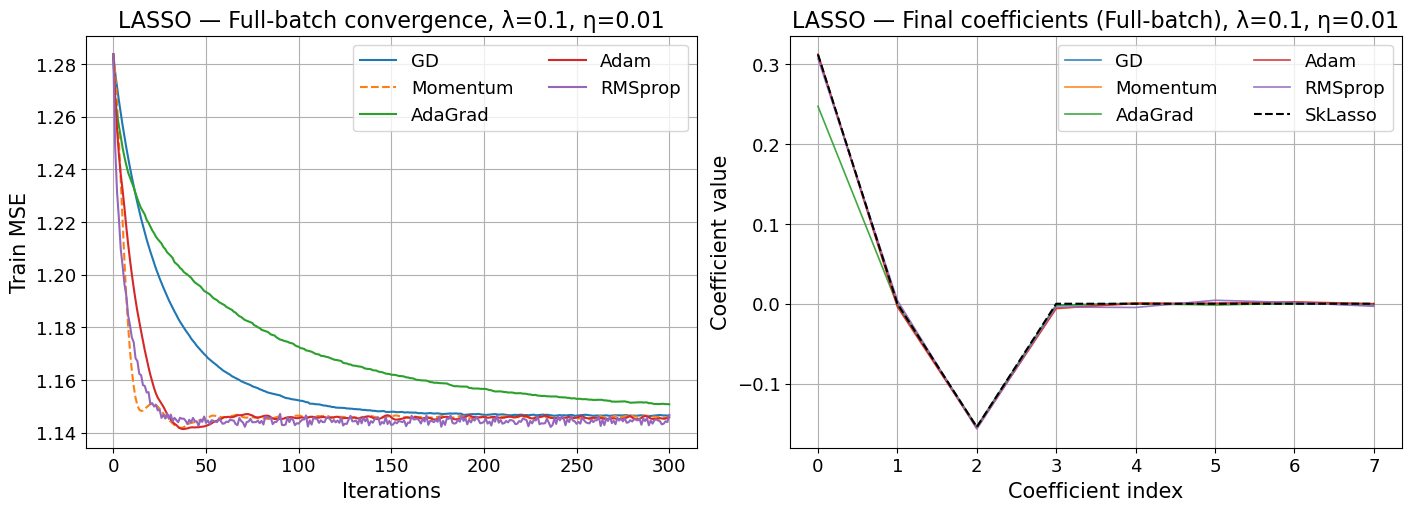

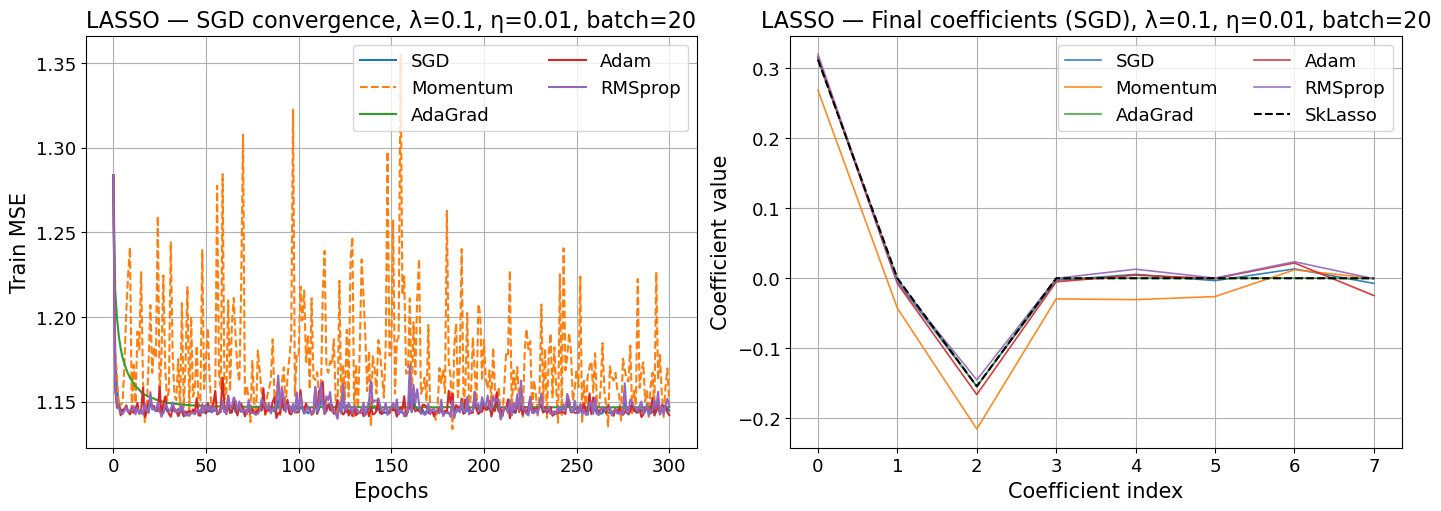

In [4]:
# LASSO (z-score features, intercept not penalized) 

# Reuse z-scored design from Ridge cell: Xz_tr, Xz_te

lasso_full = lasso_grad_full_builder(Xz_tr, y_tr, LAM, intercept_free=True)
def lasso_mb(theta, Xb, yb):
    return lasso_grad_minibatch(theta, Xb, yb, LAM, intercept_free=True)

lr_fb  = 0.01 #LR_FULL * eta_lasso
lr_sgd = 0.01 #LR_SGD  * eta_lasso

fb_lasso = train_full_batch_family(lasso_full, Xz_tr, y_tr, lr=lr_fb,  iters=ITERS)
mb_lasso = train_sgd_family(lasso_mb,        Xz_tr, y_tr, lr=lr_sgd, epochs=ITERS, batch_size=BATCH, seed=SEED)

# "CF" for LASSO via scikit-learn (fit_intercept=True on features-only)
from sklearn.linear_model import Lasso as SkLasso
Xtr_no_ic = Xz_tr[:, 1:]           
alpha_sklearn = LAM / 2
sk = SkLasso(alpha=alpha_sklearn, fit_intercept=True, max_iter=20_000, tol=1e-7,
             selection='cyclic', random_state=SEED)
sk.fit(Xtr_no_ic, y_tr.ravel())
theta_cf_lasso = np.concatenate(([sk.intercept_], sk.coef_.ravel()))[:, None]

# Convergence plots (use Xz_tr)
conv_fb_lasso = {k: train_mse_over_traj(Xz_tr, y_tr, traj, mse) for k, (_, traj) in fb_lasso.items()}
conv_mb_lasso = {k: train_mse_over_traj(Xz_tr, y_tr, traj, mse) for k, (_, traj) in mb_lasso.items()}

# LASSO: Full-batch
fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(
    axes[0], conv_fb_lasso,
    f"LASSO — Full-batch convergence, λ={LAM:g}, η={lr_fb:g}",
    "Iterations", ylabel="Train MSE",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plot_final_coeffs_with_cf(
    axes[1], fb_lasso, theta_cf_lasso,
    f"LASSO — Final coefficients (Full-batch), λ={LAM:g}, η={lr_fb:g}",
    cf_label="SkLasso",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plt.savefig("LassoGD.pdf", dpi=300)
plt.show()

# LASSO: SGD 
fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
plot_convergence(
    axes[0], conv_mb_lasso,
    f"LASSO — SGD convergence, λ={LAM:g}, η={lr_sgd:g}, batch={BATCH}",
    "Epochs", ylabel="Train MSE",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plot_final_coeffs_with_cf(
    axes[1], mb_lasso, theta_cf_lasso,
    f"LASSO — Final coefficients (SGD), λ={LAM:g}, η={lr_sgd:g}, batch={BATCH}",
    cf_label="SkLasso",
    fontsize_title=16, fontsize_label=15, fontsize_legend=13
)
plt.savefig("LassoSGD.pdf", dpi=300)
plt.show()